## This is a AI sudoku solver using deep learning and some image processing.

In [1]:
# importing the necessary libraries
import cv2
import os
import operator
import tensorflow
import numpy as np
from sklearn.metrics import f1_score 
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [2]:
# function for solving sudoku using backtracking and printing the solved sudoku
board = [
    [7,8,0,4,0,0,1,2,0],
    [6,0,0,0,7,5,0,0,9],
    [0,0,0,6,0,1,0,7,8],
    [0,0,7,0,4,0,2,6,0],
    [0,0,1,0,5,0,9,3,0],
    [9,0,4,0,6,0,0,0,5],
    [0,7,0,3,0,0,0,1,2],
    [1,2,0,0,0,7,4,0,0],
    [0,4,9,2,0,6,0,0,7]
]

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col

    return None

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True

def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False

print_board(board)
solve(board)
print("\n_________________________\n")
print_board(board)

7 8 0  | 4 0 0  | 1 2 0
6 0 0  | 0 7 5  | 0 0 9
0 0 0  | 6 0 1  | 0 7 8
- - - - - - - - - - - - - 
0 0 7  | 0 4 0  | 2 6 0
0 0 1  | 0 5 0  | 9 3 0
9 0 4  | 0 6 0  | 0 0 5
- - - - - - - - - - - - - 
0 7 0  | 3 0 0  | 0 1 2
1 2 0  | 0 0 7  | 4 0 0
0 4 9  | 2 0 6  | 0 0 7

_________________________

7 8 5  | 4 3 9  | 1 2 6
6 1 2  | 8 7 5  | 3 4 9
4 9 3  | 6 2 1  | 5 7 8
- - - - - - - - - - - - - 
8 5 7  | 9 4 3  | 2 6 1
2 6 1  | 7 5 8  | 9 3 4
9 3 4  | 1 6 2  | 7 8 5
- - - - - - - - - - - - - 
5 7 8  | 3 9 4  | 6 1 2
1 2 6  | 5 8 7  | 4 9 3
3 4 9  | 2 1 6  | 8 5 7


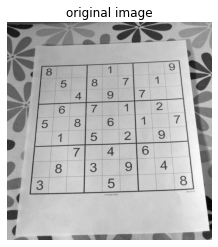

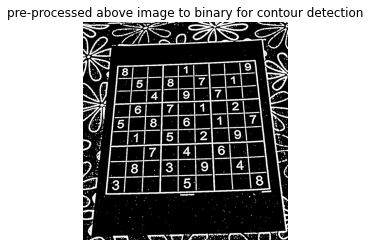

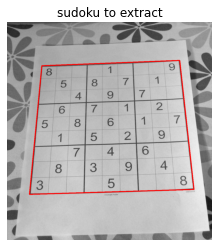

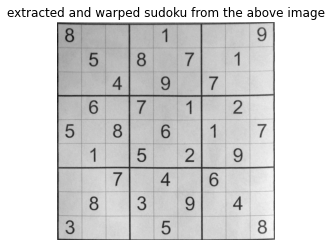

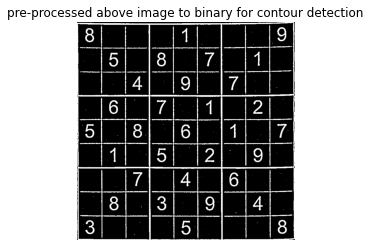

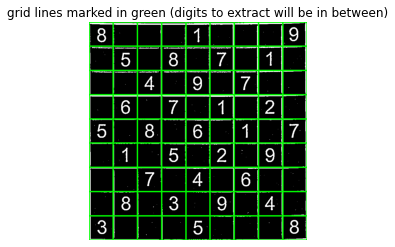

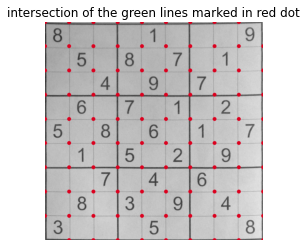

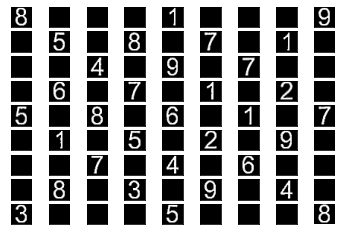

In [3]:
# functions for image processing
def plot_many_images(images, titles='', rows=9, columns=9):
    """Plots each image in a given list as a grid structure. using Matplotlib."""
    plt.title('Extracted elements from sudoku')
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.axis('off')
    plt.show()


def show_image(img, title='', flag=0):
    if flag!=0:
        return True
    """Shows an image until any key is pressed"""
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


def pre_process_image(img, skip_dilate=False, flag=0):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)

    if not skip_dilate:
        # Dilate the image to increase the size of the grid lines.
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
        proc = cv2.dilate(proc, kernel)

    show_image(proc, 'pre-processed above image to binary for contour detection', flag)
    return proc


def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]


def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect, flag=0):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
        ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    warp = cv2.warpPerspective(img, m, (int(side), int(side)))
    show_image(warp, 'extracted and warped sudoku from the above image', flag)
    
    return warp


def infer_grid(img):
    """Infers 81 cell grid from a square image."""
    squares = []
    side = img.shape[:1]
    side = side[0] / 9

    # Note that we swap j and i here so the rectangles are stored in the list reading left-right instead of top-down.
    for j in range(9):
        for i in range(9):
            p1 = (i * side, j * side)  # Top left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares


def cut_from_rect(img, rect):
    """Cuts a rectangle from an image using the top left and bottom right points."""
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]


def scale_and_centre(img, size, margin=0, background=0):
    """Scales and centres an image onto a new background square."""
    h, w = img.shape[:2]

    def centre_pad(length):
        """Handles centering for a given length that may be odd or even."""
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))


def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    """
    Uses the fact the `floodFill` function returns a bounding box of the area it filled to find the biggest
    connected pixel structure in the image. Fills this structure in white, reducing the rest to black.
    """
    img = inp_img.copy()  # Copy the image, leaving the original untouched
    height, width = img.shape[:2]

    max_area = 0
    seed_point = (None, None)

    if scan_tl is None:
        scan_tl = [0, 0]

    if scan_br is None:
        scan_br = [width, height]

    # Loop through the image
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            # Only operate on light or white squares
            if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid
                    max_area = area[0]
                    seed_point = (x, y)

    # Colour everything grey (compensates for features outside of our middle scanning range
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)

    mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image

    # Highlight the main feature
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = height, 0, width, 0

    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:  # Hide anything that isn't the main feature
                cv2.floodFill(img, mask, (x, y), 0)

            # Find the bounding parameters
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point


def extract_digit(img, rect, size):
    """Extracts a digit (if one exists) from a Sudoku square."""

    digit = cut_from_rect(img, rect)  # Get the digit box from the whole square

    # Use fill feature finding to get the largest feature in middle of the box
    # Margin used to define an area in the middle we would expect to find a pixel belonging to the digit
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = cut_from_rect(digit, bbox)

    # Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]

    # Ignore any small bounding boxes
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)


def get_digits(img, squares, size, flag=0):
    """Extracts digits from their cells and builds an array"""
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True, flag=flag)
    ii = img.copy()
    ii = cv2.cvtColor(ii, cv2.COLOR_GRAY2BGR)
    for square in squares:
        digits.append(extract_digit(img, square, size))
        a,b = (int(square[0][0]),int(square[0][1])), (int(square[1][0]),int(square[1][1]))
        cv2.rectangle(ii, a, b, (0,255,0), 3)
    show_image(ii, 'grid lines marked in green (digits to extract will be in between)', flag)
    return digits


def parse_grid(path, flag=0):
    original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    rgb_img = cv2.cvtColor(original.copy(), cv2.COLOR_BGR2RGB)
    show_image(original, 'original image', flag)

    processed = pre_process_image(original, flag=flag)
    corners = find_corners_of_largest_polygon(processed)
    cv2.line(rgb_img, tuple(corners[0]), tuple(corners[1]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[1]), tuple(corners[2]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[2]), tuple(corners[3]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[3]), tuple(corners[0]), (255,0,0), 3)
    show_image(rgb_img, 'sudoku to extract', flag)
    
    cropped = crop_and_warp(original, corners, flag)
    squares = infer_grid(cropped)
    digits = get_digits(cropped, squares, 28, flag=flag)
    warp_img = cv2.cvtColor(cropped.copy(), cv2.COLOR_BGR2RGB)
    for a,b in squares:
        x,y = int(a[0]), int(a[1])
        w,z = int(b[0]), int(b[1])
        cv2.circle(warp_img, (x,y), 7, (220,0,30), -1)
        cv2.circle(warp_img, (w,z), 7, (220,0,30), -1)
    show_image(warp_img, 'intersection of the green lines marked in red dot', flag)
    return digits

path = '../input/ai-sudoku-solver-data/'
digits = parse_grid(path+'sudoku.jpg', flag=0)
plot_many_images(digits)

In [4]:
# creating the model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (16,16), input_shape=(28, 28, 1), activation='relu'))
    model.add(Conv2D(8, (8,8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(units=11, activation='softmax'))
    return model

In [5]:
# Gathering the data for training the model
def get_data():
    data = pd.read_csv('../input/ai-sudoku-solver-data/image_data.csv')
    X = []
    Y = data['y']
    del data['y']
    for i in range(data.shape[0]):
        flat_pixels = data.iloc[i].values[1:]
        image = np.reshape(flat_pixels, (28,28))
        X.append(image)

    X = np.array(X)
    Y = np.array(Y)

    # split the data into training (50%) and testing (50%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.1, random_state=22)

    #reshaping data
    X_train = X_train.reshape(-1,28,28,1)
    X_test  = X_test.reshape(-1,28,28,1)
    return X_train, X_test

In [6]:
# Getting predictions from the trained model
def predict_digits(model, digits):
    dic = {}
    char = "1234567890"
    for i,c in enumerate(char):
        dic[i+1] = c
    sudoku = []
    row = []
    for i,dig in enumerate(digits):
        img = dig.reshape(-1,28,28,1)
        pred = model.predict_classes(img)[0]
        character = dic[pred]
        row.append(int(character))
        if((i+1)%9==0):
            sudoku.append(row)
            row = []
    return np.array(sudoku)

In [7]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

def train_model(model):
    X_train, X_test = get_data()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1score])
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=35, batch_size=16, verbose=2)
    return model

In [8]:
# main function takes the sudoku image file path as input
def main(path):
    digits = parse_grid(path, flag=1)
    model = create_model()
    if 'model.h5' in os.listdir('../input/ai-sudoku-solver-data'):
        model.load_weights('../input/ai-sudoku-solver-data/model.h5')
    else:
        model = train_model(model)
        
    sudoku = predict_digits(model, digits)
    solve(sudoku)
    print('solved output:\n')
    print_board(sudoku)

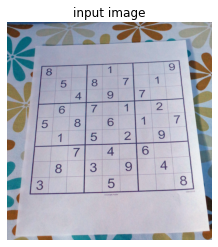

In [11]:
img = cv2.imread(path+'sudoku.jpg')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('input image')
plt.show()

In [12]:
main(path+'sudoku.jpg')

solved output:

8 7 2  | 4 1 3  | 5 6 9
9 5 6  | 8 2 7  | 3 1 4
1 3 4  | 6 9 5  | 7 8 2
- - - - - - - - - - - - - 
4 6 9  | 7 3 1  | 8 2 5
5 2 8  | 9 6 4  | 1 3 7
7 1 3  | 5 8 2  | 4 9 6
- - - - - - - - - - - - - 
2 9 7  | 1 4 8  | 6 5 3
6 8 5  | 3 7 9  | 2 4 1
3 4 1  | 2 5 6  | 9 7 8
